In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from itertools import cycle
import random

from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import label_binarize
from sklearn.multiclass import OneVsRestClassifier
from scipy import interp
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from matplotlib import pyplot

from scipy.optimize import differential_evolution

In [2]:
import os
dataset = pd.read_csv(os.path.join(os.getcwd(), 'data/pima_indian_data.csv'))

# creating input features and target variables
X = np.asarray(dataset.iloc[:,0:8], dtype=np.float32)
y = np.asarray(dataset.iloc[:,8], dtype=np.float32)

#standardizing the input feature
sc = StandardScaler()
X = sc.fit_transform(X)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)
num_features = X_train.shape[1]

# Train with RF
rf = RandomForestClassifier(n_estimators=25, random_state=3)
rf.fit(X_train, y_train)
rf_probs = rf.predict_proba(X_test)
# Train with LR
lr = LogisticRegression(solver='lbfgs')
lr.fit(X_train, y_train)
# predict probabilities
lr_probs = lr.predict_proba(X_test)

# keep probabilities for the positive outcome only
rf_probs = rf_probs[:, 1]
lr_probs = lr_probs[:, 1]

RF: ROC AUC=0.821
LS: ROC AUC=0.802


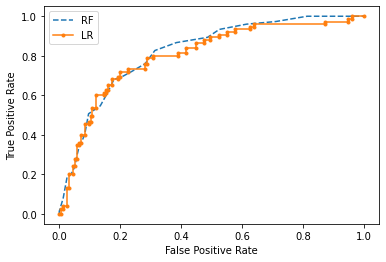

In [3]:
# calculate scores
rf_auc = roc_auc_score(y_test, rf_probs)
lr_auc = roc_auc_score(y_test, lr_probs)

# summarize scores
print('RF: ROC AUC=%.3f' % (rf_auc))
print('LS: ROC AUC=%.3f' % (lr_auc))

# calculate roc curves
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_probs)
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)

# plot the roc curve for the model
pyplot.plot(rf_fpr, rf_tpr, linestyle='--', label='RF')
pyplot.plot(lr_fpr, lr_tpr, marker='.', label='LR')

# axis labels
pyplot.xlabel('False Positive Rate')
pyplot.ylabel('True Positive Rate')

# show the legend
pyplot.legend()
# show the plot



# ConeOpt

In [4]:
print("ER (train) = {}".format(sum(y_train)/len(y_train)))
print("ER (test) = {}".format(sum(y_test)/len(y_test)))
#np.select(y_test == 1, y_test)

# get current point and reference point 
idx_y_test_pos = np.argwhere(y_test == 1).flatten()
idx_y_test_neg = np.argwhere(y_test == 0).flatten()

idx_curr = idx_y_test_pos[5]
idx_ref = idx_y_test_neg[4]

print("=" * 80)
X_curr = X_test[idx_curr:idx_curr+1, :]
print("Y (curr) has prob = ", lr.predict_proba(X_curr)[:, 1])
print("X (curr) = ", X_curr)

print("=" * 80)
X_ref = X_test[idx_ref:idx_ref+1, :]
print("Y (ref) has prob = ", lr.predict_proba(X_ref)[:, 1])
print("X (ref) = ", X_ref)




ER (train) = 0.3582089552238806
ER (test) = 0.3246753246753247
Y (curr) has prob =  [0.86330464]
X (curr) =  [[-0.25002164  2.0696416   0.04641078  0.09297736  1.0424324   0.5593035
  -0.19220549  0.23678604]]
Y (ref) has prob =  [0.08120282]
X (ref) =  [[-0.546874   -1.0595031  -0.5735673  -0.28334787 -0.24220139  0.08999533
  -0.9227028  -0.69981205]]


In [5]:
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html#r108fc14fa019-1

def run_coneopt(X_curr, X_ref, max_step = 0.3, fixed_features = []):

    print("=" * 80)
    X_cone = X_ref - X_curr
    print("Cone = ",  X_cone)

    bounds = list(zip(X_curr.flatten(), (X_curr + X_cone * max_step).flatten()))
    for b in range(len(bounds)):
        bound = bounds[b]
        if bound[0] > bound[1]:
            bounds[b] = bound[1], bound[0]

    for idx_feat in fixed_features:
        bounds[idx_feat] = (X_curr[0][idx_feat], X_curr[0][idx_feat])
    print("Bounds = ", bounds)

    #print(X_curr, X_curr + X_cone * max_step)

    def my_predict_proba(x, method):
        return method.predict_proba(x.reshape(1, len(x)))[:, 1]

    result = differential_evolution(
        func=my_predict_proba, 
        bounds=bounds, 
        args=[lr],
        disp=True,
        seed=0)
    X_opt = result.x.reshape(1, len(result.x))

    print("=" * 80)
    print("CURR")
    print("Y (curr) has prob = ", lr.predict_proba(X_curr)[:, 1])
    print("X (curr) = ", X_curr)

    print("=" * 80)
    print("OPT")
    print("Y (opt) has prob = ", lr.predict_proba(X_opt)[:, 1])
    print("X (opt) = ", X_opt)

    print("=" * 80)
    print("REF")
    print("Y (ref) has prob = ", lr.predict_proba(X_ref)[:, 1])
    print("X (ref) = ", X_ref)

    print("=" * 80)
    
    return X_opt
    
    
#https://docs.scipy.org/doc/scipy/reference/generated/scipy.optimize.differential_evolution.html#r108fc14fa019-1

def run_coneopt2(X_curr, X_ref, max_step = 0.3, fixed_features = []):

    print("=" * 80)
    X_cone = X_ref - X_curr
    print("Cone = ",  X_cone)

    bounds = list(zip(X_curr.flatten(), (X_curr + X_cone * max_step).flatten()))
    for b in range(len(bounds)):
        bound = bounds[b]
        if bound[0] > bound[1]:
            bounds[b] = bound[1], bound[0]

    bounds2 = []
    fixed_x = []
    non_fixed_features = []
    for b in range(len(bounds)):
        if b not in set(fixed_features):
            bounds2.append(bounds[b])
            non_fixed_features.append(b)
        else:
            fixed_x.append(X_curr[0][b]) 
    num_features = len(bounds)
    bounds = bounds2
    num_features_active = len(bounds)
    print("Bounds = ", bounds)
    print("fixed_features = ", fixed_features)
    print("fixed_x = ", fixed_x)
    print("non_fixed_features = ", non_fixed_features)

    #print(X_curr, X_curr + X_cone * max_step)

    def get_full_x(non_fixed_x, fixed_features, non_fixed_features, fixed_x):
        full_x = [b for b in range(len(fixed_features) + len(non_fixed_features))]
        for b in range(len(non_fixed_features)):
            full_x[non_fixed_features[b]] = non_fixed_x[b]
        for b in range(len(fixed_features)):
            full_x[fixed_features[b]] = fixed_x[b]
        return full_x

    def my_predict_proba(non_fixed_x, method, fixed_features, non_fixed_features, fixed_x):
        if non_fixed_features == []:
            return method.predict_proba(x.reshape(1, len(x)))[:, 1]
        else:
            full_x = get_full_x(non_fixed_x, fixed_features, non_fixed_features, fixed_x)
            #print("non_fixed_features", non_fixed_features)
            #print("fixed_features", fixed_features)
            return method.predict_proba(np.array(full_x).reshape(1, len(full_x)))[:, 1]

    result = differential_evolution(
        func=my_predict_proba, 
        bounds=bounds, 
        args=[lr, fixed_features, non_fixed_features, fixed_x],
        disp=True,
        seed=0)
    
    full_x = get_full_x(result.x, fixed_features, non_fixed_features, fixed_x)
    X_opt = np.array(full_x).reshape(1, len(full_x))

    print("=" * 80)
    print("CURR")
    print("Y (curr) has prob = ", lr.predict_proba(X_curr)[:, 1])
    print("X (curr) = ", X_curr)

    print("=" * 80)
    print("OPT")
    print("Y (opt) has prob = ", lr.predict_proba(X_opt)[:, 1])
    print("X (opt) = ", X_opt)

    print("=" * 80)
    print("REF")
    print("Y (ref) has prob = ", lr.predict_proba(X_ref)[:, 1])
    print("X (ref) = ", X_ref)

    print("=" * 80)
    
    return X_opt
        

In [6]:
def identify_fixed_features(
    X_curr,
    X_opt,
    influential_features_percentage = 0.5, 
    delta_feature_eps = 0.0001):

    # Identify the most influential features -- 50% of the most important features.
    #influential_features_percentage = 0.5 
    #delta_feature_eps = 0.0001
    
    num_features = X_curr.shape[1]
    diff = list(map(abs, X_opt.flatten() - X_curr.flatten()))
    for i in range(len(diff)):
        if diff[i] == 0:
            diff[i] += random.randrange(100)*delta_feature_eps
    num_features_changed = sum(np.array(diff) > delta_feature_eps)

    num_target_features = int(max(1, influential_features_percentage * num_features_changed))
    print("Will use [{}] feautres for the analysis".format(num_target_features))

    #print("diff", diff)
    #print("list(map(abs, X_curr))", list(map(abs, X_curr)))
    delta_changes = np.divide(diff, list(map(abs, X_curr)))[0]
    print("delta_changes = ", delta_changes)
    cutoff_feature_value = sorted(delta_changes, reverse = True)[num_target_features - 1]
    print("Cutoff feature values (only feature with values >= cutoff will be included) = {}".format(cutoff_feature_value))
    flag_required_feature = delta_changes >= cutoff_feature_value
    
    #print(idx_required_feature)
    assert(sum(flag_required_feature) == num_target_features)
    
    return [i for i in range(num_features) if flag_required_feature[i]==False]
    


In [7]:
max_step = 0.35

X_opt_init = run_coneopt(X_curr, X_ref, max_step=max_step, fixed_features=[])
fixed_features = identify_fixed_features(X_curr, X_opt_init)
print(fixed_features)

#X_opt = run_coneopt(X_curr, X_ref, max_step=max_step, fixed_features=fixed_features)
X_opt = run_coneopt2(X_curr, X_ref, max_step=max_step, fixed_features=fixed_features)
#X_opt = run_coneopt(X_curr, X_ref, max_step=max_step, fixed_features=fixed_features)


Cone =  [[-0.29685235 -3.1291447  -0.6199781  -0.37632525 -1.2846339  -0.4693082
  -0.7304973  -0.93659806]]
Bounds =  [(-0.35391995, -0.25002164), (0.97444093, 2.0696416), (-0.17058153, 0.046410784), (-0.038736477, 0.09297736), (0.5928106, 1.0424324), (0.39504564, 0.5593035), (-0.44787955, -0.19220549), (-0.09102327, 0.23678604)]
differential_evolution step 1: f(x)= 0.59389
differential_evolution step 2: f(x)= 0.573098
differential_evolution step 3: f(x)= 0.570045
differential_evolution step 4: f(x)= 0.570045
differential_evolution step 5: f(x)= 0.570045
differential_evolution step 6: f(x)= 0.570045
differential_evolution step 7: f(x)= 0.570045
differential_evolution step 8: f(x)= 0.568798
differential_evolution step 9: f(x)= 0.566948
differential_evolution step 10: f(x)= 0.566948
differential_evolution step 11: f(x)= 0.565765
differential_evolution step 12: f(x)= 0.565306
CURR
Y (curr) has prob =  [0.86330464]
X (curr) =  [[-0.25002164  2.0696416   0.04641078  0.09297736  1.0424324  

# NO NEED

In [174]:
print("Y (curr) has prob = ", lr.predict_proba(X_curr)[:, 1])
print("X (curr) = ", X_curr)

X_opt = result.x.reshape(1, len(result.x))
print("Y (opt) has prob = ", lr.predict_proba(X_opt)[:, 1])
print("X (opt) = ", X_opt)

Y (curr) has prob =  [0.90827086]
X (curr) =  [[2.1247969  1.0683153  0.3563998  0.4693026  0.60843456 0.16609915
  2.6603563  1.5139652 ]]
Y (opt) has prob =  [0.53369112]
X (opt) =  [[ 0.49428485  0.33325735  0.32808709  0.29517624  0.54907977 -0.21322886
   1.8112237   0.72292829]]


In [3]:
from __future__ import absolute_import, division, print_function, unicode_literals

import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split
from tensorflow.keras import backend as k


In [4]:
    pd.set_option('display.max_columns', None)
    pd.set_option('display.max_rows', None)

    # https://www.tensorflow.org/tutorials/structured_data/feature_columns
    print("ConEOpt: Contractual Explanation with Optimization")

    # Use Pandas to create a dataframe
    filepath = '/Users/AF45008/Research/ColinML/coneopt/data/heart.csv'
    dataframe = pd.read_csv(filepath)
    print(dataframe.head())

    # Split the dataframe into train, validation, and test
    train, test = train_test_split(dataframe, test_size=0.2)
    train, val = train_test_split(train, test_size=0.2)
    print(len(train), 'train examples')
    print(len(val), 'validation examples')
    print(len(test), 'test examples')

    # Create an input pipeline using tf.data
    # A utility method to create a tf.data dataset from a Pandas Dataframe
    def df_to_dataset(dataframe, shuffle=True, batch_size=32):
        dataframe = dataframe.copy()
        labels = dataframe.pop('target')
        ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
        if shuffle:
            ds = ds.shuffle(buffer_size=len(dataframe))
        ds = ds.batch(batch_size)
        return ds

    batch_size = 5  # A small batch sized is used for demonstration purposes
    train_ds = df_to_dataset(train, batch_size=batch_size)
    val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
    test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

    # Understand the input pipeline
    for feature_batch, label_batch in train_ds.take(1):
        print('Every feature:', list(feature_batch.keys()))
        print('A batch of ages:', feature_batch['age'])
        print('A batch of targets:', label_batch)

    # Numeric columns
    age = feature_column.numeric_column("age")
    print(age)

    feature_columns = []

    # numeric cols
    for header in ['age', 'trestbps', 'chol', 'thalach', 'oldpeak', 'slope', 'ca']:
      feature_columns.append(feature_column.numeric_column(header))

    # bucketized cols
    age_buckets = feature_column.bucketized_column(age, boundaries=[18, 25, 30, 35, 40, 45, 50, 55, 60, 65])
    feature_columns.append(age_buckets)

    # indicator cols
    thal = feature_column.categorical_column_with_vocabulary_list(
          'thal', ['fixed', 'normal', 'reversible'])
    thal_one_hot = feature_column.indicator_column(thal)
    feature_columns.append(thal_one_hot)

    # embedding cols
    thal_embedding = feature_column.embedding_column(thal, dimension=8)
    feature_columns.append(thal_embedding)

    # crossed cols
    crossed_feature = feature_column.crossed_column([age_buckets, thal], hash_bucket_size=1000)
    crossed_feature = feature_column.indicator_column(crossed_feature)
    feature_columns.append(crossed_feature)

    feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
    batch_size = 32
    train_ds = df_to_dataset(train, batch_size=batch_size)
    val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)
    test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)

    # Create, compile, and train the model
    model = tf.keras.Sequential([
        feature_layer,
        layers.Dense(128, activation='relu'),
        layers.Dense(128, activation='relu'),
        layers.Dense(1, activation='sigmoid')
    ])

    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])

    model.fit(train_ds,
              validation_data=val_ds,
              epochs=5)

    loss, accuracy = model.evaluate(test_ds)
    print("Accuracy", accuracy)


ConEOpt: Contractual Explanation with Optimization
   age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  slope  \
0   63    1   1       145   233    1        2      150      0      2.3      3   
1   67    1   4       160   286    0        2      108      1      1.5      2   
2   67    1   4       120   229    0        2      129      1      2.6      2   
3   37    1   3       130   250    0        0      187      0      3.5      3   
4   41    0   2       130   204    0        2      172      0      1.4      1   

   ca        thal  target  
0   0       fixed       0  
1   3      normal       1  
2   2  reversible       0  
3   0      normal       0  
4   0      normal       0  
193 train examples
49 validation examples
61 test examples
Every feature: ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg', 'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal']
A batch of ages: tf.Tensor([59 54 43 67 47], shape=(5,), dtype=int32)
A batch of targets: tf.Tensor([0 0 0 

In [9]:
model.evaluate(test_ds)
print(test)

2/2 [==============================] - 0s 3ms/step - loss: 0.5560 - accuracy: 0.7377
     age  sex  cp  trestbps  chol  fbs  restecg  thalach  exang  oldpeak  \
96    41    1   3       112   250    0        0      179      0      0.0   
283   60    0   4       150   258    0        2      157      0      2.6   
186   42    1   2       120   295    0        0      162      0      0.0   
31    60    1   4       117   230    1        0      160      1      1.4   
112   58    0   4       100   248    0        2      122      0      1.0   
266   60    1   4       130   253    0        0      144      1      1.4   
295   39    1   4       118   219    0        0      140      0      1.2   
134   42    1   3       120   240    1        0      194      0      0.8   
173   47    1   4       112   204    0        0      143      0      0.1   
248   57    0   0       140   241    0        1      123      1      0.2   
52    53    0   4       130   264    0        2      143      0      0.4   
297

In [20]:
train_ds.shape

AttributeError: 'BatchDataset' object has no attribute 'shape'

In [10]:
print(model.layers[1])


In [128]:
dataset = pd.read_csv('/Users/AF45008/Research/ColinML/coneopt/data/pima_indian_data.csv')

# creating input features and target variables
X = np.asarray(dataset.iloc[:,0:8], dtype=np.float32)
y = np.asarray(dataset.iloc[:,8], dtype=np.float32)

#standardizing the input feature
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X = sc.fit_transform(X)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)




In [157]:
import tensorflow as tf
import numpy as np

#Build the model
class model:
    
    def __init__(self):
        xavier=tf.keras.initializers.GlorotUniform()
        self.l1=tf.keras.layers.Dense(
            4, 
            kernel_initializer=xavier, 
            #activation=tf.nn.linear, 
            input_shape=[1])
        #self.l2=tf.keras.layers.Dense(
        #    2, 
        #    kernel_initializer=xavier, 
        #    #activation=tf.nn.linear
        #)
        self.out=tf.keras.layers.Dense(
            1, 
            kernel_initializer=xavier)
        self.train_op = tf.keras.optimizers.Adagrad(learning_rate=0.1)
        print(self.out)
        
    # Running the model
    def run(self,X):
        boom=self.l1(X)
        #boom1=self.l2(boom)
        boom1=boom
        boom2=self.out(boom1)
        return boom2
    
    #Custom loss fucntion
    def get_loss(self,X,Y):
        boom=self.l1(X)
        #boom1=self.l2(boom)
        boom1=boom
        boom2=self.out(boom1)
        return tf.math.square(boom2-Y)
    
    # get gradients
    def get_grad(self,X,Y):
        with tf.GradientTape() as tape:
            tape.watch(self.l1.variables)
            #tape.watch(self.l2.variables)
            tape.watch(self.out.variables)
            L = self.get_loss(X,Y)
            g = tape.gradient(L, [self.l1.variables[0],
                                  self.l1.variables[1],
                                  #self.l2.variables[0],
                                  #self.l2.variables[1],
                                  self.out.variables[0],
                                  self.out.variables[1]])
        return g
    
    # get gradients
    def get_grad2(self, X):
        with tf.GradientTape() as tape:
            tape.watch(self.l1.variables)
            #tape.watch(self.l2.variables)
            tape.watch(self.out.variables)
            g = tape.gradient(self.run(X), 
                              [self.l1.variables[0],
                               self.l1.variables[1],
                                #self.l2.variables[0],
                                #self.l2.variables[1],
                                self.out.variables[0],
                                self.out.variables[1]])
        return g
    
    # perform gradient descent
    def network_learn(self,X,Y):
        g = self.get_grad(X,Y)
        print("=" * 80)
        print(f"g={g}")
        # print(self.var)
        self.train_op.apply_gradients(
            zip(g, [self.l1.variables[0],
                    self.l1.variables[1],
                    #self.l2.variables[0],
                    #self.l2.variables[1],
                    self.out.variables[0],
                    self.out.variables[1]]))


In [158]:
#Custom training
#x=[1,2,3,4,5,6,7,8,9,10]
#x=np.asarray(x,dtype=np.float32).reshape((10,1))
#y=[1,4,9,16,25,36,49,64,81,100]
#y=np.asarray(y,dtype=np.float32).reshape((10,1))

m=model()

for i in range(2):
    m.network_learn(X_train, y_train)

    
# Test Case
#x=[11]
#x=np.asarray(x,dtype=np.float32).reshape((1,1))
#print(model.run(x))

g=[<tf.Tensor: shape=(8, 4), dtype=float32, numpy=
array([[ 839952.7  ,  350051.06 , -155563.7  , -748251.56 ],
       [ 206270.97 ,   85963.61 ,  -38202.477, -183751.52 ],
       [  51173.133,   21326.447,   -9477.538,  -45586.355],
       [-389902.53 , -162492.23 ,   72212.02 ,  347335.25 ],
       [-152099.31 ,  -63387.53 ,   28169.602,  135494.   ],
       [ 315516.84 ,  131491.92 ,  -58435.4  , -281070.56 ],
       [-176917.38 ,  -73730.47 ,   32766.035,  157602.56 ],
       [1006093.5  ,  419290.38 , -186333.9  , -896254.1  ]],
      dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 249008.38 ,  103774.484,  -46117.688, -221823.02 ], dtype=float32)>, <tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[ -708786.06],
       [-1098114.4 ],
       [  100387.67],
       [  816072.3 ]], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-228848.4], dtype=float32)>]
g=[<tf.Tensor: shape=(8, 4), dtype=float32, numpy=
array([[ 394074.2   ,  140969

In [163]:
g = m.get_grad(X_train, y_train)
g

[<tf.Tensor: shape=(8, 4), dtype=float32, numpy=
 array([[ 273064.06  ,   93991.55  ,  -39466.55  , -249433.67  ],
        [ -58423.203 ,  -20109.889 ,    8444.035 ,   53367.38  ],
        [ -26712.32  ,   -9194.664 ,    3860.791 ,   24400.691 ],
        [ -97421.58  ,  -33533.54  ,   14080.555 ,   88990.92  ],
        [   5197.2783,    1788.9595,    -751.1743,   -4747.508 ],
        [ 124758.64  ,   42943.246 ,  -18031.639 , -113962.266 ],
        [ -14599.819 ,   -5025.41  ,    2110.1448,   13336.376 ],
        [ 367553.97  ,  126515.984 ,  -53123.39  , -335746.62  ]],
       dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 7214.6   ,  2483.3396, -1042.7422, -6590.259 ], dtype=float32)>,
 <tf.Tensor: shape=(4, 1), dtype=float32, numpy=
 array([[-236536.97 ],
        [-210715.67 ],
        [   9073.932],
        [ 198444.3  ]], dtype=float32)>,
 <tf.Tensor: shape=(1,), dtype=float32, numpy=array([-7749.5654], dtype=float32)>]

In [165]:
print(m.get_grad2(X_train[0:1,:]))
print("=" * 80)
print(m.get_grad2(X_train[1:2,:]))
print(m.get_grad2(X_train[0:2,:]))



[<tf.Tensor: shape=(8, 4), dtype=float32, numpy=
array([[-0.04359787, -0.01500685,  0.0063013 ,  0.039825  ],
       [ 0.84070694,  0.28938025, -0.12150922, -0.7679539 ],
       [-0.5241901 , -0.18043183,  0.07576235,  0.4788278 ],
       [ 1.1980461 ,  0.41238022, -0.17315625, -1.0943696 ],
       [ 0.64568156,  0.22225046, -0.09332178, -0.5898056 ],
       [-1.2055811 , -0.41497383,  0.17424528,  1.1012526 ],
       [ 0.65948224,  0.2270008 , -0.09531642, -0.60241205],
       [ 0.33443257,  0.11511525, -0.04833627, -0.30549145]],
      dtype=float32)>, <tf.Tensor: shape=(4,), dtype=float32, numpy=array([-0.93096817, -0.32044914,  0.13455488,  0.8504041 ], dtype=float32)>, <tf.Tensor: shape=(4, 1), dtype=float32, numpy=
array([[-0.8798704],
       [-1.5463147],
       [-0.1866839],
       [-2.1644511]], dtype=float32)>, <tf.Tensor: shape=(1,), dtype=float32, numpy=array([1.], dtype=float32)>]
[<tf.Tensor: shape=(8, 4), dtype=float32, numpy=
array([[-0.87267804, -0.30038506,  0.1261300

In [145]:
g2_test = m.get_grad2(X_test)
g2_test

[<tf.Tensor: shape=(8, 4), dtype=float32, numpy=
 array([[-3.573741  ,  4.4614577 , -2.0754642 ,  1.1735111 ],
        [-3.9608998 ,  4.9447885 , -2.3003097 ,  1.3006427 ],
        [-0.6210106 ,  0.77526915, -0.36065477,  0.20392124],
        [ 3.7513583 , -4.6831937 ,  2.1786158 , -1.2318348 ],
        [-0.7751977 ,  0.9677548 , -0.4501989 ,  0.25455114],
        [ 3.4337068 , -4.286639  ,  1.9941385 , -1.1275274 ],
        [-2.8637142 ,  3.5750604 , -1.6631137 ,  0.9403584 ],
        [-4.6870346 ,  5.851292  , -2.7220147 ,  1.5390848 ]],
       dtype=float32)>,
 <tf.Tensor: shape=(4,), dtype=float32, numpy=array([ 65.345055, -81.576866,  37.949524, -21.457415], dtype=float32)>,
 <tf.Tensor: shape=(4, 2), dtype=float32, numpy=
 array([[ 15.225409 ,   7.9595876],
        [-18.307314 ,  -9.570757 ],
        [ 14.491468 ,   7.5758953],
        [-16.125036 ,  -8.429895 ]], dtype=float32)>,
 <tf.Tensor: shape=(2,), dtype=float32, numpy=array([138.7106 ,  72.51534], dtype=float32)>,
 <tf.Te

In [57]:
print(m.run(X_test[0:1,]))

tf.Tensor([[0.24188049]], shape=(1, 1), dtype=float32)


In [95]:
x = tf.ones((2, 2))

with tf.GradientTape() as t:
    t.watch(x)
    y = tf.reduce_sum(x)
    z = tf.multiply(y, y)

# Derivative of z with respect to the original input tensor x
dz_dx = t.gradient(z, x)
for i in [0, 1]:
    for j in [0, 1]:
        assert dz_dx[i][j].numpy() == 8.0

In [108]:
x

<tf.Tensor: shape=(2, 2), dtype=float32, numpy=
array([[1., 1.],
       [1., 1.]], dtype=float32)>

In [11]:
import tensorflow as tf
import tensorflow.keras.backend as kb
import numpy as np

# This is an ultra simple model to learn squares of numbers.
# Do not take the model too seriosuly, it will overfit and is only 
# for deminstration purpose
keras_model=tf.keras.Sequential([ 
    tf.keras.layers.Dense(32,activation=tf.nn.relu,input_shape=[1]),
    tf.keras.layers.Dense(32,activation=tf.nn.relu),
    tf.keras.layers.Dense(1)
]
)

# Now we define our custom loss function

def custom_loss(y_actual,y_pred): 
    custom_loss=kb.square(y_actual-y_pred)
    return custom_loss

optimizer=tf.keras.optimizers.RMSprop(0.001)
keras_model.compile(loss=custom_loss,optimizer=optimizer)

#Sample data
x=[1,2,3,4,5,6,7,8,9,10]
x=np.asarray(x).reshape((10,1))
y=[1,4,9,16,25,36,49,64,81,100]
y=np.asarray(y).reshape((10,1))
y=y.astype(np.float32)
keras_model.fit(x,y,batch_size=10,epochs=1000)
print(keras_model.predict([11]))

Train on 10 samples
Epoch 1/1000
10/10 [==============================] - 0s 34ms/sample - loss: 2660.8171
Epoch 2/1000
10/10 [==============================] - 0s 124us/sample - loss: 2635.6772
Epoch 3/1000
10/10 [==============================] - 0s 198us/sample - loss: 2618.0007
Epoch 4/1000
10/10 [==============================] - 0s 145us/sample - loss: 2603.4373
Epoch 5/1000
10/10 [==============================] - 0s 184us/sample - loss: 2590.6538
Epoch 6/1000
10/10 [==============================] - 0s 191us/sample - loss: 2579.0430
Epoch 7/1000
10/10 [==============================] - 0s 206us/sample - loss: 2567.2781
Epoch 8/1000
10/10 [==============================] - 0s 234us/sample - loss: 2553.9441
Epoch 9/1000
10/10 [==============================] - 0s 222us/sample - loss: 2541.9351
Epoch 10/1000
10/10 [==============================] - 0s 260us/sample - loss: 2530.7222
Epoch 11/1000
10/10 [==============================] - 0s 259us/sample - loss: 2520.2920
Epoch 12/10

Epoch 93/1000
10/10 [==============================] - 0s 210us/sample - loss: 1913.9395
Epoch 94/1000
10/10 [==============================] - 0s 265us/sample - loss: 1905.1631
Epoch 95/1000
10/10 [==============================] - 0s 252us/sample - loss: 1896.3289
Epoch 96/1000
10/10 [==============================] - 0s 275us/sample - loss: 1887.4375
Epoch 97/1000
10/10 [==============================] - 0s 274us/sample - loss: 1878.4893
Epoch 98/1000
10/10 [==============================] - 0s 195us/sample - loss: 1869.4854
Epoch 99/1000
10/10 [==============================] - 0s 298us/sample - loss: 1860.4258
Epoch 100/1000
10/10 [==============================] - 0s 444us/sample - loss: 1851.3113
Epoch 101/1000
10/10 [==============================] - 0s 193us/sample - loss: 1842.1420
Epoch 102/1000
10/10 [==============================] - 0s 195us/sample - loss: 1832.9183
Epoch 103/1000
10/10 [==============================] - 0s 284us/sample - loss: 1823.6414
Epoch 104/1000
10

10/10 [==============================] - 0s 357us/sample - loss: 955.9576
Epoch 185/1000
10/10 [==============================] - 0s 325us/sample - loss: 944.8666
Epoch 186/1000
10/10 [==============================] - 0s 240us/sample - loss: 933.7998
Epoch 187/1000
10/10 [==============================] - 0s 243us/sample - loss: 922.7587
Epoch 188/1000
10/10 [==============================] - 0s 222us/sample - loss: 911.7446
Epoch 189/1000
10/10 [==============================] - 0s 315us/sample - loss: 900.7595
Epoch 190/1000
10/10 [==============================] - 0s 186us/sample - loss: 889.8043
Epoch 191/1000
10/10 [==============================] - 0s 182us/sample - loss: 878.8809
Epoch 192/1000
10/10 [==============================] - 0s 268us/sample - loss: 867.9908
Epoch 193/1000
10/10 [==============================] - 0s 202us/sample - loss: 857.1354
Epoch 194/1000
10/10 [==============================] - 0s 242us/sample - loss: 846.3165
Epoch 195/1000
10/10 [==============

Epoch 277/1000
10/10 [==============================] - 0s 221us/sample - loss: 235.6644
Epoch 278/1000
10/10 [==============================] - 0s 276us/sample - loss: 233.2824
Epoch 279/1000
10/10 [==============================] - 0s 202us/sample - loss: 231.0132
Epoch 280/1000
10/10 [==============================] - 0s 210us/sample - loss: 228.8526
Epoch 281/1000
10/10 [==============================] - 0s 329us/sample - loss: 226.7962
Epoch 282/1000
10/10 [==============================] - 0s 243us/sample - loss: 224.8396
Epoch 283/1000
10/10 [==============================] - 0s 222us/sample - loss: 222.9787
Epoch 284/1000
10/10 [==============================] - 0s 272us/sample - loss: 221.2095
Epoch 285/1000
10/10 [==============================] - 0s 177us/sample - loss: 219.5286
Epoch 286/1000
10/10 [==============================] - 0s 189us/sample - loss: 217.9333
Epoch 287/1000
10/10 [==============================] - 0s 200us/sample - loss: 216.4209
Epoch 288/1000
10/10 

10/10 [==============================] - 0s 252us/sample - loss: 184.2745
Epoch 370/1000
10/10 [==============================] - 0s 220us/sample - loss: 184.0255
Epoch 371/1000
10/10 [==============================] - 0s 271us/sample - loss: 183.7766
Epoch 372/1000
10/10 [==============================] - 0s 385us/sample - loss: 183.5281
Epoch 373/1000
10/10 [==============================] - 0s 299us/sample - loss: 183.2800
Epoch 374/1000
10/10 [==============================] - 0s 176us/sample - loss: 183.0319
Epoch 375/1000
10/10 [==============================] - 0s 214us/sample - loss: 182.7845
Epoch 376/1000
10/10 [==============================] - 0s 220us/sample - loss: 182.5373
Epoch 377/1000
10/10 [==============================] - 0s 216us/sample - loss: 182.2906
Epoch 378/1000
10/10 [==============================] - 0s 244us/sample - loss: 182.0443
Epoch 379/1000
10/10 [==============================] - 0s 223us/sample - loss: 181.7986
Epoch 380/1000
10/10 [==============

Epoch 462/1000
10/10 [==============================] - 0s 182us/sample - loss: 164.8008
Epoch 463/1000
10/10 [==============================] - 0s 234us/sample - loss: 164.6164
Epoch 464/1000
10/10 [==============================] - 0s 211us/sample - loss: 164.4310
Epoch 465/1000
10/10 [==============================] - 0s 176us/sample - loss: 164.2469
Epoch 466/1000
10/10 [==============================] - 0s 213us/sample - loss: 164.0620
Epoch 467/1000
10/10 [==============================] - 0s 192us/sample - loss: 163.8786
Epoch 468/1000
10/10 [==============================] - 0s 246us/sample - loss: 163.6945
Epoch 469/1000
10/10 [==============================] - 0s 256us/sample - loss: 163.5119
Epoch 470/1000
10/10 [==============================] - 0s 185us/sample - loss: 163.3285
Epoch 471/1000
10/10 [==============================] - 0s 198us/sample - loss: 163.1467
Epoch 472/1000
10/10 [==============================] - 0s 247us/sample - loss: 162.9641
Epoch 473/1000
10/10 

10/10 [==============================] - 0s 300us/sample - loss: 148.3217
Epoch 555/1000
10/10 [==============================] - 0s 216us/sample - loss: 148.1414
Epoch 556/1000
10/10 [==============================] - 0s 299us/sample - loss: 147.9598
Epoch 557/1000
10/10 [==============================] - 0s 216us/sample - loss: 147.7791
Epoch 558/1000
10/10 [==============================] - 0s 310us/sample - loss: 147.5972
Epoch 559/1000
10/10 [==============================] - 0s 243us/sample - loss: 147.4161
Epoch 560/1000
10/10 [==============================] - 0s 251us/sample - loss: 147.2338
Epoch 561/1000
10/10 [==============================] - 0s 349us/sample - loss: 147.0522
Epoch 562/1000
10/10 [==============================] - 0s 386us/sample - loss: 146.8694
Epoch 563/1000
10/10 [==============================] - 0s 350us/sample - loss: 146.6874
Epoch 564/1000
10/10 [==============================] - 0s 211us/sample - loss: 146.5042
Epoch 565/1000
10/10 [==============

Epoch 647/1000
10/10 [==============================] - 0s 318us/sample - loss: 130.0256
Epoch 648/1000
10/10 [==============================] - 0s 265us/sample - loss: 129.8046
Epoch 649/1000
10/10 [==============================] - 0s 202us/sample - loss: 129.5841
Epoch 650/1000
10/10 [==============================] - 0s 288us/sample - loss: 129.3618
Epoch 651/1000
10/10 [==============================] - 0s 211us/sample - loss: 129.1401
Epoch 652/1000
10/10 [==============================] - 0s 179us/sample - loss: 128.9164
Epoch 653/1000
10/10 [==============================] - 0s 266us/sample - loss: 128.6934
Epoch 654/1000
10/10 [==============================] - 0s 497us/sample - loss: 128.4683
Epoch 655/1000
10/10 [==============================] - 0s 243us/sample - loss: 128.2438
Epoch 656/1000
10/10 [==============================] - 0s 271us/sample - loss: 128.0175
Epoch 657/1000
10/10 [==============================] - 0s 280us/sample - loss: 127.7916
Epoch 658/1000
10/10 

10/10 [==============================] - 0s 215us/sample - loss: 106.3023
Epoch 740/1000
10/10 [==============================] - 0s 198us/sample - loss: 106.0056
Epoch 741/1000
10/10 [==============================] - 0s 194us/sample - loss: 105.7086
Epoch 742/1000
10/10 [==============================] - 0s 255us/sample - loss: 105.4097
Epoch 743/1000
10/10 [==============================] - 0s 238us/sample - loss: 105.1104
Epoch 744/1000
10/10 [==============================] - 0s 235us/sample - loss: 104.8094
Epoch 745/1000
10/10 [==============================] - 0s 218us/sample - loss: 104.5081
Epoch 746/1000
10/10 [==============================] - 0s 186us/sample - loss: 104.2052
Epoch 747/1000
10/10 [==============================] - 0s 322us/sample - loss: 103.9023
Epoch 748/1000
10/10 [==============================] - 0s 219us/sample - loss: 103.5976
Epoch 749/1000
10/10 [==============================] - 0s 204us/sample - loss: 103.2931
Epoch 750/1000
10/10 [==============

10/10 [==============================] - 0s 318us/sample - loss: 75.2713
Epoch 833/1000
10/10 [==============================] - 0s 298us/sample - loss: 74.9021
Epoch 834/1000
10/10 [==============================] - 0s 232us/sample - loss: 74.5284
Epoch 835/1000
10/10 [==============================] - 0s 269us/sample - loss: 74.1532
Epoch 836/1000
10/10 [==============================] - 0s 354us/sample - loss: 73.7773
Epoch 837/1000
10/10 [==============================] - 0s 299us/sample - loss: 73.4009
Epoch 838/1000
10/10 [==============================] - 0s 192us/sample - loss: 73.0357
Epoch 839/1000
10/10 [==============================] - 0s 371us/sample - loss: 72.6657
Epoch 840/1000
10/10 [==============================] - 0s 307us/sample - loss: 72.2893
Epoch 841/1000
10/10 [==============================] - 0s 272us/sample - loss: 71.9125
Epoch 842/1000
10/10 [==============================] - 0s 208us/sample - loss: 71.5381
Epoch 843/1000
10/10 [=========================

Epoch 926/1000
10/10 [==============================] - 0s 215us/sample - loss: 42.8778
Epoch 927/1000
10/10 [==============================] - 0s 179us/sample - loss: 42.5820
Epoch 928/1000
10/10 [==============================] - 0s 209us/sample - loss: 42.2918
Epoch 929/1000
10/10 [==============================] - 0s 288us/sample - loss: 41.9990
Epoch 930/1000
10/10 [==============================] - 0s 231us/sample - loss: 41.7226
Epoch 931/1000
10/10 [==============================] - 0s 207us/sample - loss: 41.4349
Epoch 932/1000
10/10 [==============================] - 0s 247us/sample - loss: 41.1561
Epoch 933/1000
10/10 [==============================] - 0s 379us/sample - loss: 40.8639
Epoch 934/1000
10/10 [==============================] - 0s 258us/sample - loss: 40.5716
Epoch 935/1000
10/10 [==============================] - 0s 180us/sample - loss: 40.2804
Epoch 936/1000
10/10 [==============================] - 0s 409us/sample - loss: 39.9980
Epoch 937/1000
10/10 [==========

In [35]:

#Custom training
x=[1,2,3,4,5,6,7,8,9,10]
x=np.asarray(x,dtype=np.float32).reshape((10,1))
y=[1,4,9,16,25,36,49,64,81,100]
y=np.asarray(y,dtype=np.float32).reshape((10,1))
m=model()

for i in range(10):
    m.network_learn(x,y)

    
# Test Case
#x=[11]
#x=np.asarray(x,dtype=np.float32).reshape((1,1))
#print(m.run(x))

In [2]:
from scipy.optimize import differential_evolution
import numpy as np
def ackley(x):
    arg1 = -0.2 * np.sqrt(0.5 * (x[0] ** 2 + x[1] ** 2))
    arg2 = 0.5 * (np.cos(2. * np.pi * x[0]) + np.cos(2. * np.pi * x[1]))
    return -20. * np.exp(arg1) - np.exp(arg2) + 20. + np.e
bounds = [(-5, 5), (-5, 5)]
result = differential_evolution(ackley, bounds)
result

     fun: 4.440892098500626e-16
 message: 'Optimization terminated successfully.'
    nfev: 3153
     nit: 102
 success: True
       x: array([0., 0.])

In [170]:
train